## 対象画像
- ラベル数：　4(dust, friction, hair, pinhole)
- 画像サイズ：　(height, width, channel) = (80, 80, 3)
- ペア数：　4ラベル合計952ペア(元画像, 各エラー画像のペアに対して1つのラベルが付与されている)

## 多クラス分類

双子モデル部分の改良による精度向上が見込めるか？

共通の前処理
- 訓練データのデータ拡張あり
  - 90,180°回転

### VGG16学習済みモデル

処理

- vgg用の正規化
- imagenetの学習ずみモデルをimport
- Batch Norm、GlobalAveragePooling2Dを追加(前回と同様、Batch Normなしでは学習が進まず)

結果

- 学習は進む
 - val_accu : 70~80あたり
 - 結果が安定しない(val_lossが大きく変動する)

### skip connectionの活用(1)

処理

- 特徴量を3回に分岐させて使用する
  - 細かい情報と抽象的な情報両面を判断材料に使うことで精度が向上するのでは？
- それぞれの抽象度のベクトルについて要素ごとの距離を産出し、連結する

結果

- 学習は進む
  - 分岐させないパターンと同程度のval_accuracy(80前後)

### skip connectionの活用(2)

処理

- 特徴量を3次元のまま扱う(3回とも3次元のままSiameseの出力とする)
- サイズを合わせるためにConv2DTransposeを使用する
- 要素ごとの距離を取った後、3つの特徴量を合わせる
  - 以上の操作から、2つの画像の変化を特徴量として抽出できるのでは？

結果

- 学習は進む
  - val_accu : 99まで上昇
  - 差分が抽出しやすいデータによるものなのかを検証するために別画像でも検証


In [ ]:
# セットアップ

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, Cropping2D, Dense, Dropout,GlobalAveragePooling2D, MaxPool2D, Concatenate, BatchNormalization, Flatten, Add, Subtract
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

class_word = ['dust', 'friction', 'hair', 'pinhole']
IMG_SHAPE = (80, 80, 3)
BATCH_SIZE = 16

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [ ]:
# GPU動作確認
!nvidia-smi

Mon Apr 26 23:19:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def get_dataset_slice_paths(image_dir, k):
  '''
  画像のパスリストを返す
  '''
  image_file_list = os.listdir(image_dir + k)
  image_paths = [os.path.join(image_dir+k, fname) for fname in image_file_list]

  return image_paths

In [ ]:
# x:[元画像, エラー画像]のペア y:ラベルのone hot表現を作る

train_data = []
train_label = []

for i, k in enumerate(class_word):
  training_image_path = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
  training_image_path.sort()
  for j in range(0, len(training_image_path), 2):
    im1 = np.array(Image.open(training_image_path[j]))
    im2 = np.array(Image.open(training_image_path[j+1]))
    train_data.append([im1, im2])
    one_hot = [1 if m == i else 0 for m in range(4)]
    train_label.append(one_hot)

train_data = np.array(train_data)
train_label = np.array(train_label)

train_data.shape, train_label.shape

((952, 2, 80, 80, 3), (952, 4))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# データ拡張
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.2)
train = []
label = []
for i in range(len(x_train)):
  train.append(x_train[i])
  train.append([np.rot90(x_train[i,0]), np.rot90(x_train[i,1])])
  train.append([np.rot90(x_train[i,0], 2), np.rot90(x_train[i,1], 2)])
  label.append(y_train[i])
  label.append(y_train[i])
  label.append(y_train[i])
x_train = np.array(train)
y_train = np.array(label)

x_train.shape, y_train.shape

((2283, 2, 80, 80, 3), (2283, 4))

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


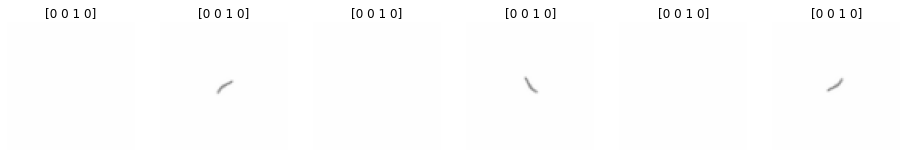

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(16,8))
cnt = 0

for i in range(3):
  for j in range(2):
    ax[cnt].imshow(x_train[i, j])
    ax[cnt].set_axis_off()
    ax[cnt].set_title(y_train[i])
    cnt += 1

<a id='sec1'></a>

### VGG学習済みモデル

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [ ]:
from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))
x = vgg.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)


vgg = Model(inputs=vgg.input, outputs=x)
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
______________________________________________________________

In [ ]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

modelA = vgg(imgA)
modelB = vgg(imgB)

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.square(A - B)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(4, activation='softmax')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 512)          14716736    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           model[0][0]                

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [ ]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=5)
)

Epoch 1/100
143/143 [==============================] - 52s 113ms/step - loss: 1.1952 - accuracy: 0.6132 - val_loss: 307.3100 - val_accuracy: 0.5707
Epoch 2/100
143/143 [==============================] - 13s 91ms/step - loss: 1.0004 - accuracy: 0.6119 - val_loss: 0.8710 - val_accuracy: 0.5759
Epoch 3/100
143/143 [==============================] - 13s 91ms/step - loss: 0.9313 - accuracy: 0.6192 - val_loss: 0.8606 - val_accuracy: 0.5759
Epoch 4/100
143/143 [==============================] - 13s 91ms/step - loss: 0.8753 - accuracy: 0.6257 - val_loss: 0.7559 - val_accuracy: 0.6387
Epoch 5/100
143/143 [==============================] - 13s 92ms/step - loss: 0.7882 - accuracy: 0.6287 - val_loss: 0.9032 - val_accuracy: 0.5707
Epoch 6/100
143/143 [==============================] - 13s 92ms/step - loss: 0.7572 - accuracy: 0.6466 - val_loss: 0.6412 - val_accuracy: 0.6754
Epoch 7/100
143/143 [==============================] - 13s 92ms/step - loss: 0.6721 - accuracy: 0.7005 - val_loss: 0.6778 - val

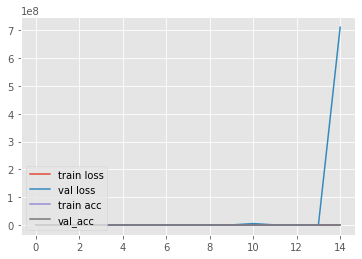

In [ ]:
def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

plot_training(history)

## 前回と同じ実装

In [ ]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size=2)(x)

    pooled_output = GlobalAveragePooling2D()(x)
    # pooled_output = Flatten()(x)
    outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, outputs)
    return model

model = build_siamese_model(IMG_SHAPE)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 64)        256 

In [ ]:
# １つのインスタンスを共有することでパラメータを共有する

IMG_SHAPE = (80, 80, 3)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)

# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.square(A - B)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(4, activation='softmax')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 48)           37616       input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 48)           0           model_3[0][0]              

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [ ]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
)

Epoch 1/100
143/143 [==============================] - 4s 18ms/step - loss: 1.1321 - accuracy: 0.6128 - val_loss: 0.8477 - val_accuracy: 0.6178
Epoch 2/100
143/143 [==============================] - 2s 15ms/step - loss: 0.8974 - accuracy: 0.7052 - val_loss: 0.7459 - val_accuracy: 0.6754
Epoch 3/100
143/143 [==============================] - 2s 15ms/step - loss: 0.7192 - accuracy: 0.7918 - val_loss: 0.6814 - val_accuracy: 0.7225
Epoch 4/100
143/143 [==============================] - 2s 15ms/step - loss: 0.5952 - accuracy: 0.8217 - val_loss: 0.6095 - val_accuracy: 0.7644
Epoch 5/100
143/143 [==============================] - 2s 15ms/step - loss: 0.5686 - accuracy: 0.8224 - val_loss: 0.5630 - val_accuracy: 0.8168
Epoch 6/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4898 - accuracy: 0.8463 - val_loss: 0.5055 - val_accuracy: 0.8534
Epoch 7/100
143/143 [==============================] - 2s 15ms/step - loss: 0.4028 - accuracy: 0.8651 - val_loss: 0.5009 - val_accuracy:

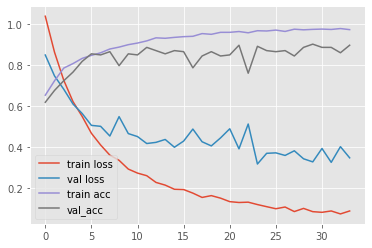

In [ ]:
def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

plot_training(history)

## 中間特徴量の抜き出し

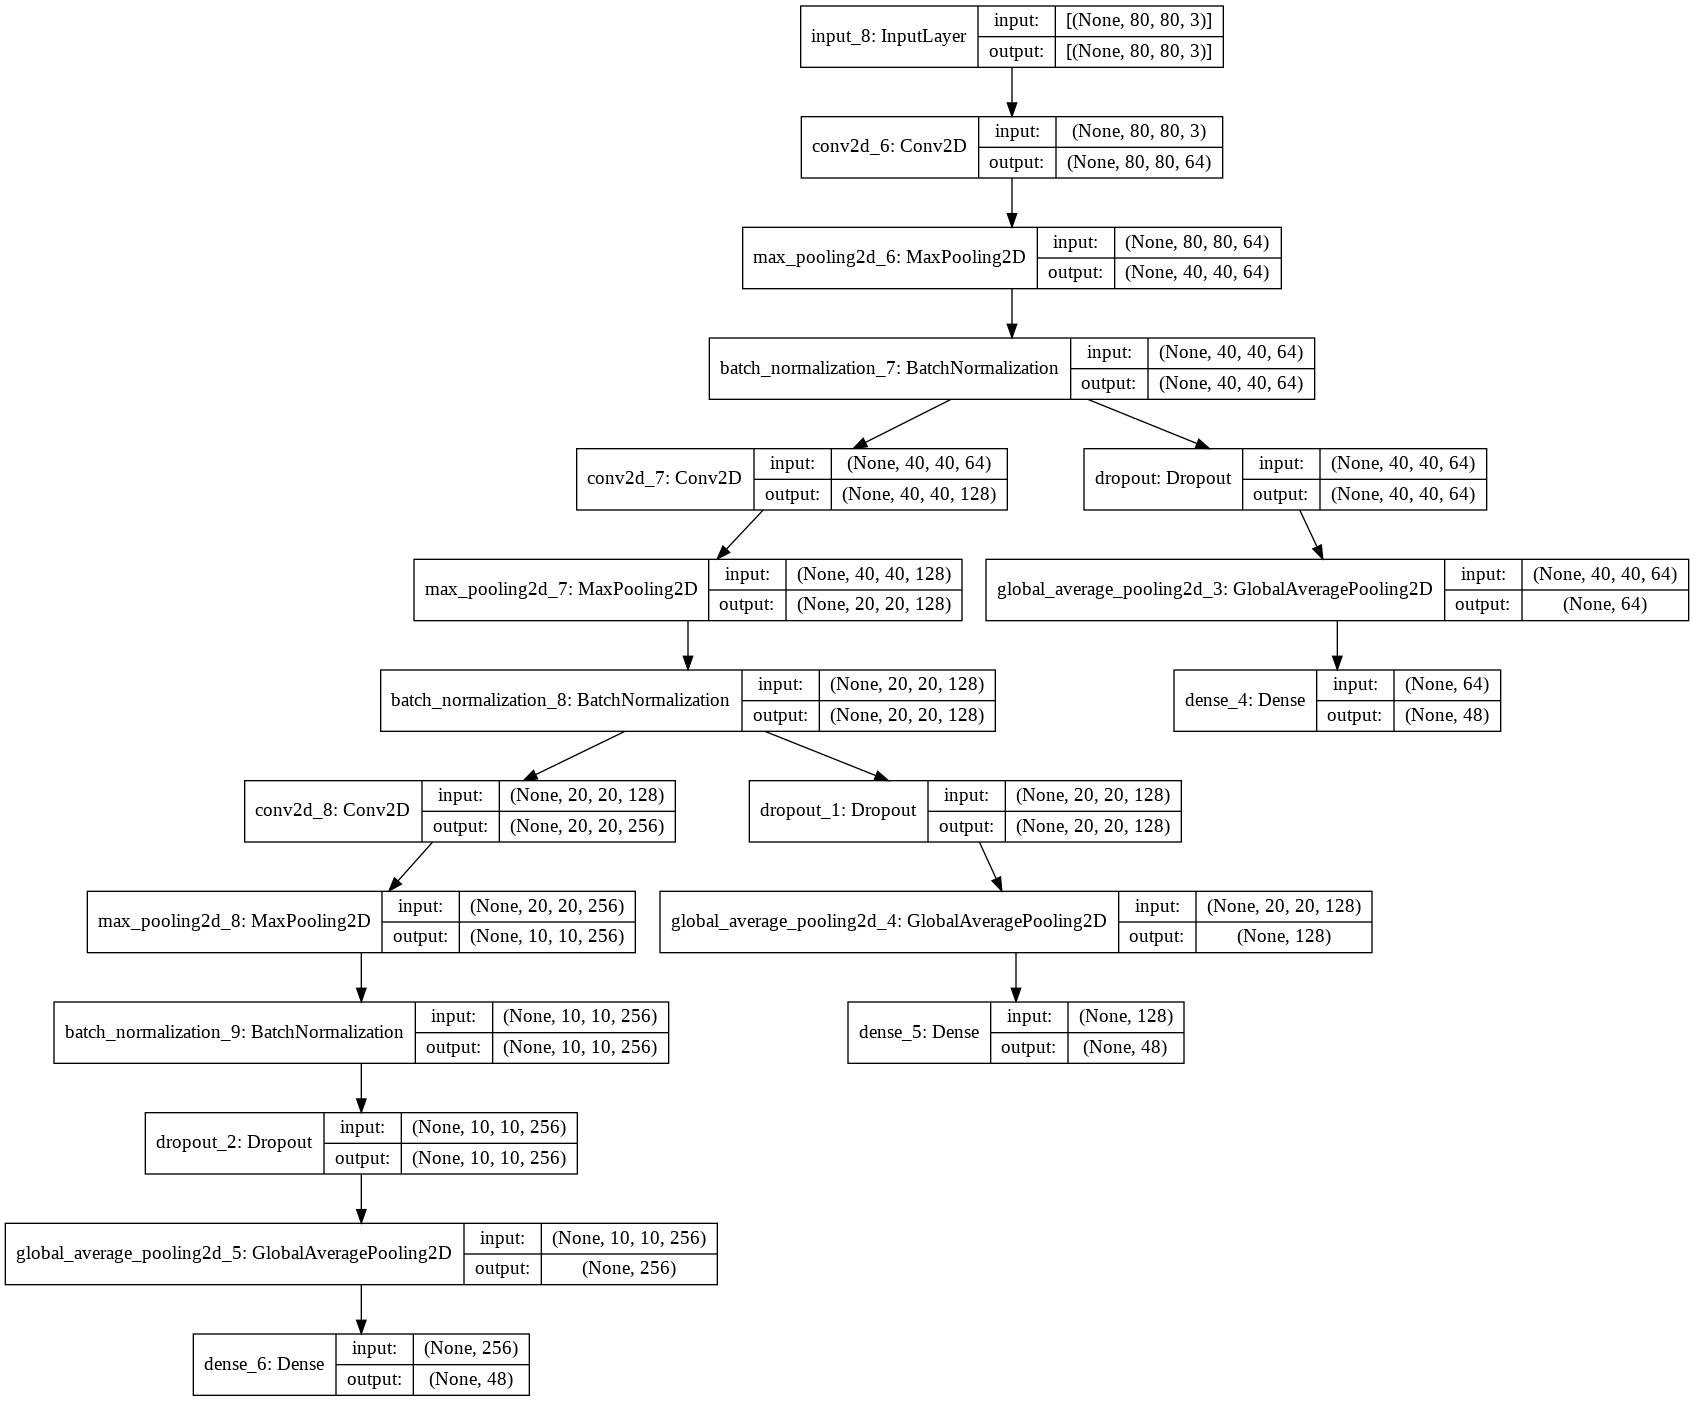

In [ ]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    out1 = x
    out1 = Dropout(0.3)(out1)
    out1 = GlobalAveragePooling2D()(out1)
    out1 = Dense(output_dim)(out1)

    x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    out2 = x
    out2 = Dropout(0.3)(out2)
    out2 = GlobalAveragePooling2D()(out2)
    out2 = Dense(output_dim)(out2)

    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size=(2,2))(x)
    # x = BatchNormalization()(x)
    # out3 = x
    # out3 = Dropout(0.3)(out3)
    # out3 = GlobalAveragePooling2D()(out3)
    # out3 = Dense(output_dim)(out3)


    x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    pooled_output = GlobalAveragePooling2D()(x)
    # pooled_output = Flatten()(x)
    outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, [out1, out2, outputs])
    return model

model = build_siamese_model(IMG_SHAPE)
plot_model(model, show_shapes=True)

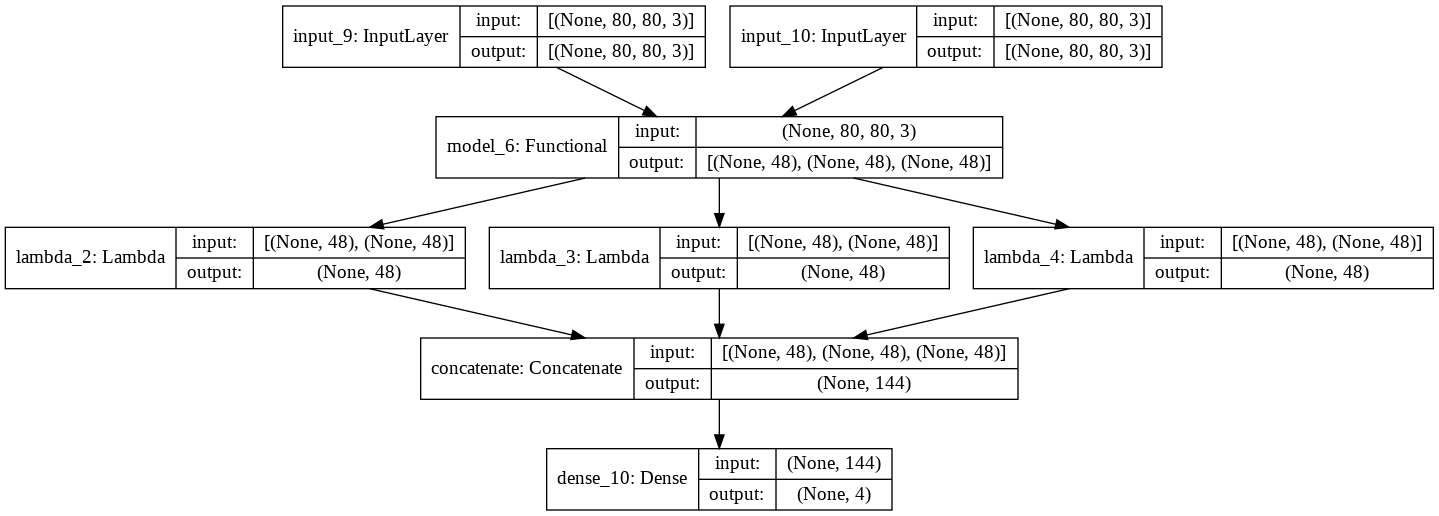

In [ ]:
# １つのインスタンスを共有することでパラメータを共有する

IMG_SHAPE = (80, 80, 3)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
A1,A2,A3 = feature_extractor(imgA)
B1,B2,B3 = feature_extractor(imgB)

# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.square(A - B)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist1 = Lambda(euclidean_distance)([A1, B1])
dist2 = Lambda(euclidean_distance)([A2, B2])
dist3 = Lambda(euclidean_distance)([A3, B3])
# dist4 = Lambda(euclidean_distance)([A4, B4])
dist = Concatenate()([dist1, dist2, dist3])
outputs = Dense(4, activation='softmax')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [ ]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
)

Epoch 1/100
143/143 [==============================] - 6s 27ms/step - loss: 1.0704 - accuracy: 0.6452 - val_loss: 0.8335 - val_accuracy: 0.6754
Epoch 2/100
143/143 [==============================] - 3s 23ms/step - loss: 0.8167 - accuracy: 0.7269 - val_loss: 0.7547 - val_accuracy: 0.6754
Epoch 3/100
143/143 [==============================] - 3s 23ms/step - loss: 0.6481 - accuracy: 0.7759 - val_loss: 0.6397 - val_accuracy: 0.6911
Epoch 4/100
143/143 [==============================] - 3s 23ms/step - loss: 0.5284 - accuracy: 0.8151 - val_loss: 0.5336 - val_accuracy: 0.7592
Epoch 5/100
143/143 [==============================] - 3s 23ms/step - loss: 0.4618 - accuracy: 0.8355 - val_loss: 0.4832 - val_accuracy: 0.7958
Epoch 6/100
143/143 [==============================] - 3s 23ms/step - loss: 0.3719 - accuracy: 0.8679 - val_loss: 0.4968 - val_accuracy: 0.8272
Epoch 7/100
143/143 [==============================] - 3s 23ms/step - loss: 0.3843 - accuracy: 0.8620 - val_loss: 0.4909 - val_accuracy:

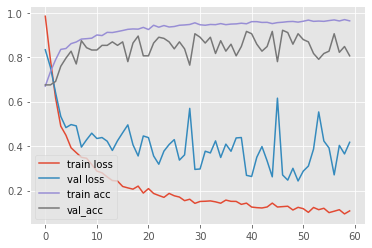

In [ ]:
def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

plot_training(history)

# Flattenを行わず、Conv Transposeで形を合わせてみる

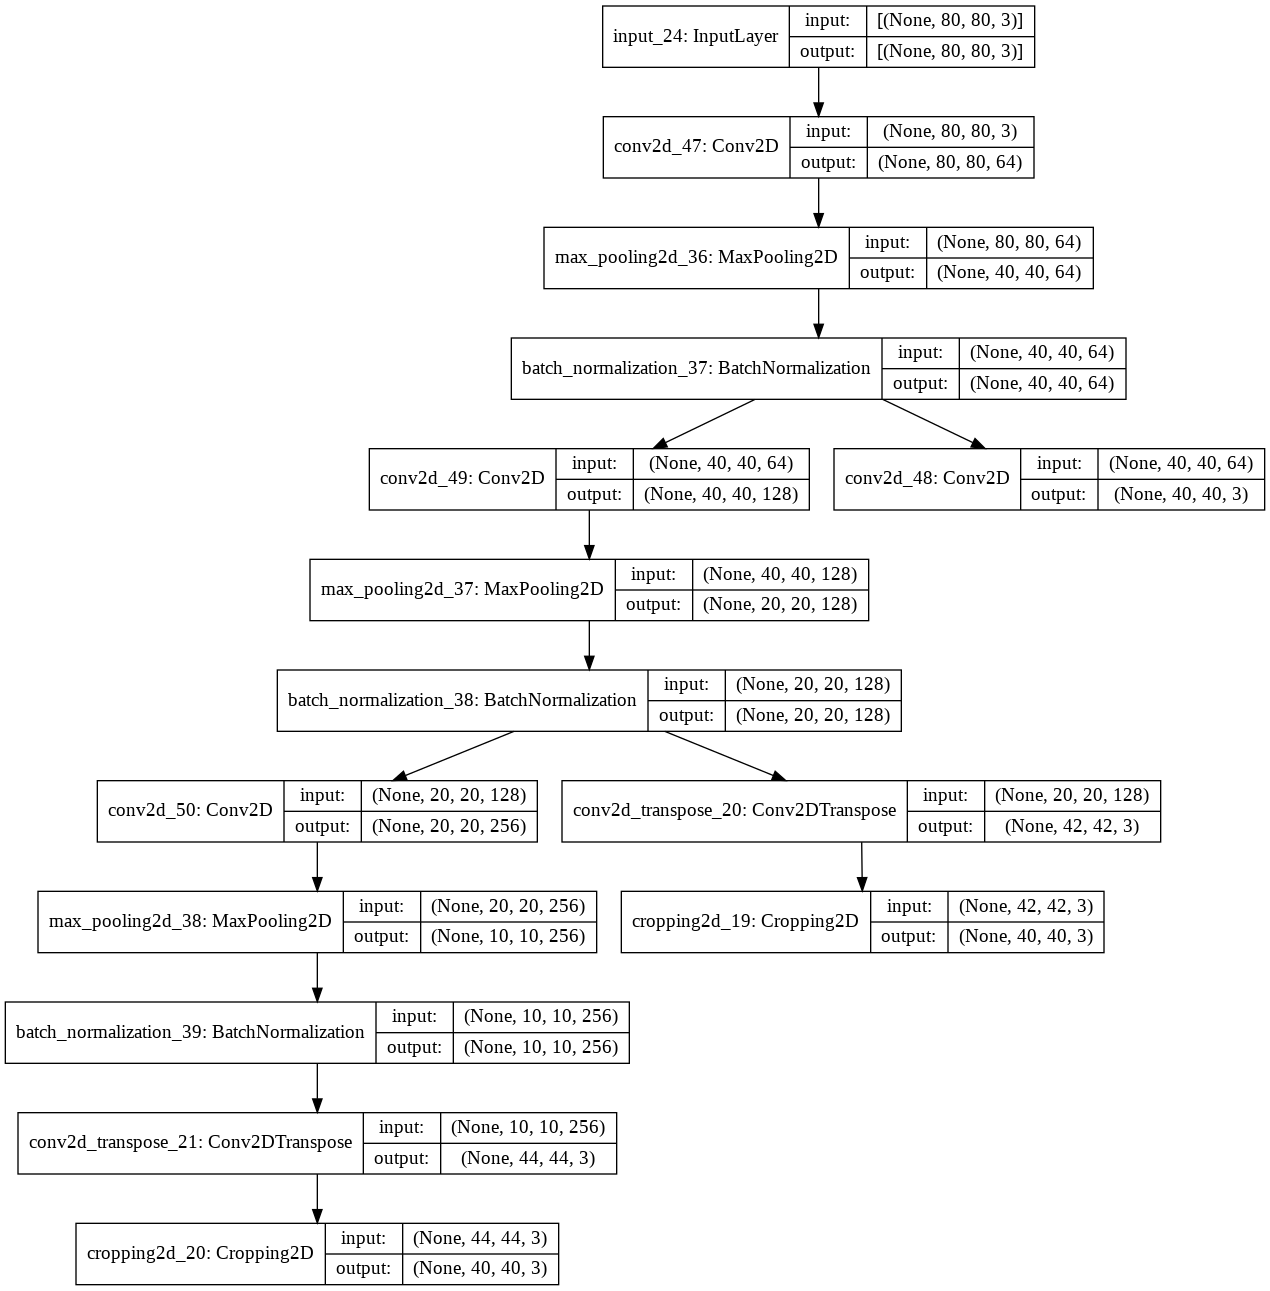

In [ ]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    out1 = x
    # out1 = Dropout(0.3)(out1)
    out1 = Conv2D(3, (1,1), activation='relu')(out1)

    x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    out2 = x
    # out2 = Dropout(0.3)(out2)
    out2 = Conv2DTranspose(3, kernel_size=(4,4),strides=(2,2))(out2)
    out2 = Cropping2D(cropping=(1,1))(out2)

    x = Conv2D(256, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    pooled_output = Conv2DTranspose(3, kernel_size=(8,8),strides=(4,4))(x)
    # pooled_output = Flatten()(x)
    outputs = Cropping2D(cropping=(2,2))(pooled_output)
    
    model = Model(inputs, [out1, out2, outputs])
    return model

model = build_siamese_model(IMG_SHAPE)
plot_model(model, show_shapes=True)

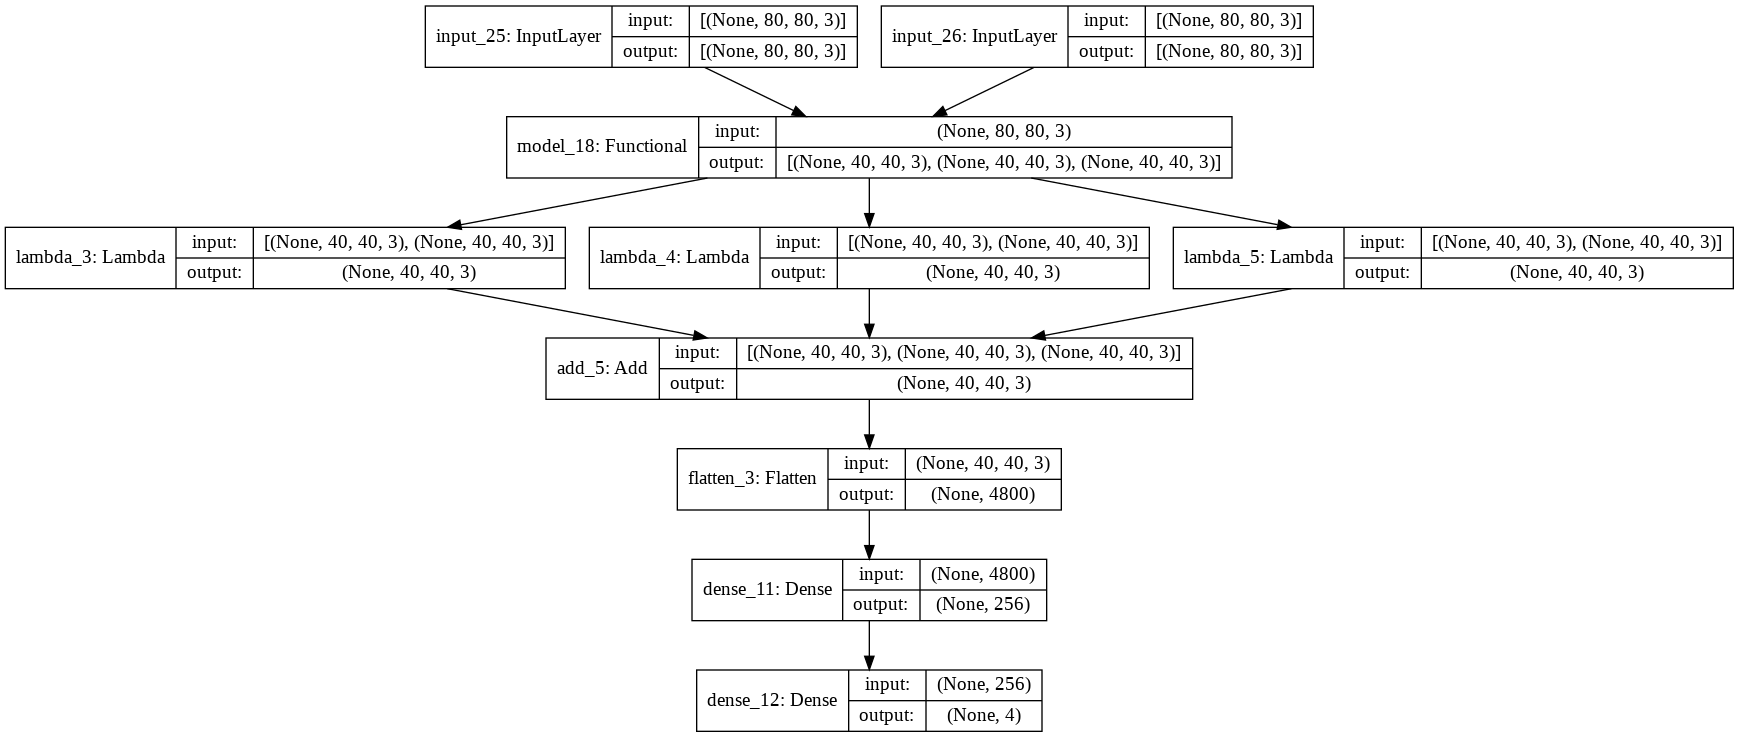

In [ ]:
# １つのインスタンスを共有することでパラメータを共有する

IMG_SHAPE = (80, 80, 3)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
A1,A2,A3 = feature_extractor(imgA)
B1,B2,B3 = feature_extractor(imgB)

# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.square(A - B)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist1 = Lambda(euclidean_distance)([A1, B1])
dist2 = Lambda(euclidean_distance)([A2, B2])
dist3 = Lambda(euclidean_distance)([A3, B3])
dist = Add()([dist1, dist2, dist3])
dist = Flatten()(dist)
dist = Dense(256, activation='relu')(dist)
outputs = Dense(4, activation='softmax')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [ ]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
)

Epoch 1/100
143/143 [==============================] - 6s 28ms/step - loss: 0.9770 - accuracy: 0.7899 - val_loss: 0.0754 - val_accuracy: 0.9738
Epoch 2/100
143/143 [==============================] - 4s 25ms/step - loss: 0.1660 - accuracy: 0.9590 - val_loss: 0.0351 - val_accuracy: 0.9895
Epoch 3/100
143/143 [==============================] - 4s 25ms/step - loss: 0.0975 - accuracy: 0.9775 - val_loss: 0.0202 - val_accuracy: 0.9948
Epoch 4/100
143/143 [==============================] - 4s 25ms/step - loss: 0.0831 - accuracy: 0.9767 - val_loss: 0.0934 - val_accuracy: 0.9581
Epoch 5/100
143/143 [==============================] - 4s 25ms/step - loss: 0.0735 - accuracy: 0.9727 - val_loss: 0.0183 - val_accuracy: 0.9948
Epoch 6/100
143/143 [==============================] - 4s 25ms/step - loss: 0.0608 - accuracy: 0.9823 - val_loss: 0.0346 - val_accuracy: 0.9948
Epoch 7/100
143/143 [==============================] - 4s 25ms/step - loss: 0.0748 - accuracy: 0.9812 - val_loss: 0.0035 - val_accuracy:

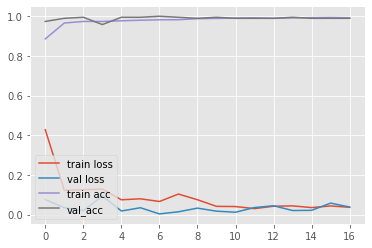

In [ ]:
def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

plot_training(history)